# Error Analysis: MET On-View Predictor

This notebook provides a deep-dive analysis of model **errors** to understand:
- **Where** the model makes mistakes (which departments, time periods, etc.)
- **Why** errors occur (confidence levels, feature patterns)
- **Patterns** in false positives vs false negatives
- **Characteristics** of misclassified objects
- **Potential areas** for model improvement

> **Note**: For basic performance metrics (accuracy, precision, recall, F1, AUC), see the `evaluate.ipynb` notebook. This notebook focuses specifically on understanding and analyzing errors.

## Analysis Sections

1. **Setup & Data Loading**: Load model, predictions, and link to metadata
2. **Error Distribution Overview**: Confusion matrix and error type breakdown
3. **Error Analysis by Metadata Features**: Errors by department, culture, period, dates
4. **Prediction Confidence Analysis**: How confidence relates to errors
5. **Feature Importance**: Which features are most important for predictions
6. **Error Examples**: Specific examples of misclassified objects
7. **Error Patterns Summary**: Key insights and patterns


In [1]:
"""
Import required libraries and set up environment.
"""
import sys
from pathlib import Path
from typing import Tuple, Dict, List, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from catboost import CatBoostClassifier

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["font.size"] = 10

# Ensure we can import from parent directory if needed
project_root = Path(".").resolve()
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

print(f"Python: {sys.executable}")
print(f"Working directory: {project_root}")


Python: D:\virtual-env\art-predictor-env\Scripts\python.exe
Working directory: D:\tu\art-display-predictor\notebooks


## 1. Setup & Configuration

Define paths and constants used throughout the analysis.


In [2]:
# Configuration
CONFIG = {
    "data_dir": Path("../data"),
    "splits_dir": Path("../data/splits_e5large"),  # Use e5large splits to match model
    "models_dir": Path("models"),
    "model_filename": "catboost_model_optimized_parameters_PRAUC_1000iter_e5large.cbm",
    "metadata_file": Path("../data/meta_for_model_e5large.parquet"),
    "full_metadata_file": Path("../data/df_train_clean.parquet"),
    "random_state": 42,
    "test_size": 0.15,
    "val_size": 0.15,
    "threshold": 0.5,  # Default classification threshold
}

# Verify paths exist
for key, path in CONFIG.items():
    if isinstance(path, Path) and "dir" in key:
        if not path.exists():
            print(f"Warning: {key} path does not exist: {path}")
    elif isinstance(path, Path) and path.suffix:  # It's a file
        if not path.exists():
            print(f"Warning: {key} path does not exist: {path}")

print("Configuration loaded successfully")


Configuration loaded successfully


## 2. Load Model and Data

Load the trained model and test/validation datasets.


In [3]:
def load_splits(splits_dir: Path) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, List[str]]:
    """
    Load train, validation, and test splits.
    
    Returns:
        X_train, y_train, X_val, y_val, X_test, y_test, feature_columns
    """
    train = np.load(splits_dir / "train.npz", allow_pickle=True)
    val = np.load(splits_dir / "val.npz", allow_pickle=True)
    test = np.load(splits_dir / "test.npz", allow_pickle=True)
    
    X_train = train["X"].astype(np.float32)
    y_train = train["y"].astype(int)
    
    X_val = val["X"].astype(np.float32)
    y_val = val["y"].astype(int)
    
    X_test = test["X"].astype(np.float32)
    y_test = test["y"].astype(int)
    
    feature_columns = np.load(
        splits_dir / "feature_columns.npy",
        allow_pickle=True
    ).tolist()
    
    return X_train, y_train, X_val, y_val, X_test, y_test, feature_columns


def load_model(model_path: Path) -> CatBoostClassifier:
    """Load the trained CatBoost model."""
    model = CatBoostClassifier()
    model.load_model(str(model_path))
    return model


# Drop columns that were removed during training
# Note: Must match exactly what was used during training!
# Based on training.ipynb, only these 3 columns were removed:
COLS_TO_REMOVE = ["isTimelineWork", "isPublicDomain", "accessionYear"]

# Load splits
X_train, y_train, X_val, y_val, X_test, y_test, feature_columns = load_splits(CONFIG["splits_dir"])

print(f"Loaded splits:")
print(f"  Train: {X_train.shape[0]} samples, {X_train.shape[1]} features")
print(f"  Val:   {X_val.shape[0]} samples")
print(f"  Test:  {X_test.shape[0]} samples")
print(f"  Feature columns: {len(feature_columns)}")

# Load model
model_path = CONFIG["models_dir"] / CONFIG["model_filename"]
model = load_model(model_path)
print(f"\nModel loaded from: {model_path}")


Loaded splits:
  Train: 350690 samples, 1029 features
  Val:   61887 samples
  Test:  72808 samples
  Feature columns: 1029

Model loaded from: models\catboost_model_optimized_parameters_PRAUC_1000iter_e5large.cbm


In [4]:
def apply_feature_drop(X: np.ndarray, feature_columns: List[str], cols_to_remove: List[str]) -> Tuple[np.ndarray, List[str]]:
    """
    Remove specified columns from feature matrix and column list.
    
    Args:
        X: Feature matrix
        feature_columns: List of feature column names
        cols_to_remove: Columns to remove
        
    Returns:
        Updated X and feature_columns
    """
    X_updated = X.copy()
    feature_columns_updated = feature_columns.copy()
    
    # Only remove columns that exist and haven't been removed already
    cols_to_drop = [col for col in cols_to_remove if col in feature_columns_updated]
    
    if cols_to_drop:
        drop_indices = [feature_columns_updated.index(col) for col in cols_to_drop]
        drop_indices_sorted = sorted(drop_indices, reverse=True)
        
        for idx in drop_indices_sorted:
            X_updated = np.delete(X_updated, idx, axis=1)
            feature_columns_updated.pop(idx)
        
        print(f"Dropped columns: {cols_to_drop}")
    else:
        print("No columns to drop (already removed or don't exist)")
    
    return X_updated, feature_columns_updated


# Apply feature dropping to match training configuration
X_val_processed, feature_columns_processed = apply_feature_drop(X_val, feature_columns, COLS_TO_REMOVE)
X_test_processed, _ = apply_feature_drop(X_test, feature_columns, COLS_TO_REMOVE)

print(f"\nProcessed features: {len(feature_columns_processed)}")


Dropped columns: ['isTimelineWork', 'isPublicDomain', 'accessionYear']
Dropped columns: ['isTimelineWork', 'isPublicDomain', 'accessionYear']

Processed features: 1026


In [5]:
def get_predictions(
    model: CatBoostClassifier,
    X: np.ndarray,
    y_true: np.ndarray,
    threshold: float = 0.5
) -> Dict[str, np.ndarray]:
    """
    Get predictions and probabilities from model.
    
    Returns:
        Dictionary with 'proba', 'pred', 'true' keys
    """
    y_proba = model.predict_proba(X)[:, 1]
    y_pred = (y_proba >= threshold).astype(int)
    
    return {
        "proba": y_proba,
        "pred": y_pred,
        "true": y_true,
    }


# Get predictions for validation and test sets
val_preds = get_predictions(model, X_val_processed, y_val, CONFIG["threshold"])
test_preds = get_predictions(model, X_test_processed, y_test, CONFIG["threshold"])

print("Predictions generated:")
print(f"  Val set - Mean probability: {val_preds['proba'].mean():.4f}")
print(f"  Test set - Mean probability: {test_preds['proba'].mean():.4f}")


Predictions generated:
  Val set - Mean probability: 0.1553
  Test set - Mean probability: 0.1577


## 3. Link Predictions to Metadata

Recreate the data split to link predictions back to original object metadata.


In [6]:
def recreate_splits(
    metadata_df: pd.DataFrame,
    test_size: float = 0.15,
    val_size: float = 0.15,
    random_state: int = 42
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Recreate train/val/test splits using same logic as training.
    
    Returns:
        train_indices, val_indices, test_indices
    """
    from sklearn.model_selection import train_test_split
    
    y = metadata_df["label_isOnView"].astype(int).values
    indices = np.arange(len(metadata_df))
    
    # Test split
    idx_temp, idx_test = train_test_split(
        indices,
        test_size=test_size,
        stratify=y,
        random_state=random_state,
    )
    
    # Train/val split
    idx_train, idx_val = train_test_split(
        idx_temp,
        test_size=val_size,
        stratify=y[idx_temp],
        random_state=random_state,
    )
    
    return idx_train, idx_val, idx_test


# Load metadata
metadata_df = pd.read_parquet(CONFIG["metadata_file"])
print(f"Loaded metadata: {metadata_df.shape}")
print(f"Columns: {metadata_df.columns.tolist()}")

# Recreate splits to get indices
idx_train, idx_val, idx_test = recreate_splits(
    metadata_df,
    test_size=CONFIG["test_size"],
    val_size=CONFIG["val_size"],
    random_state=CONFIG["random_state"]
)

print(f"\nSplit indices:")
print(f"  Train: {len(idx_train)}")
print(f"  Val:   {len(idx_val)}")
print(f"  Test:  {len(idx_test)}")

# Verify split matches loaded data
assert len(idx_val) == len(y_val), "Validation split size mismatch!"
assert len(idx_test) == len(y_test), "Test split size mismatch!"


Loaded metadata: (485385, 7)
Columns: ['objectID', 'label_isOnView', 'objectBeginDate', 'objectEndDate', 'accessionYear', 'isTimelineWork', 'isPublicDomain']

Split indices:
  Train: 350690
  Val:   61887
  Test:  72808


In [7]:
def create_error_dataframe(
    metadata_df: pd.DataFrame,
    indices: np.ndarray,
    predictions: Dict[str, np.ndarray],
    split_name: str = "unknown"
) -> pd.DataFrame:
    """
    Create a dataframe linking predictions to metadata for error analysis.
    
    Args:
        metadata_df: Full metadata dataframe
        indices: Indices for this split
        predictions: Dictionary with 'proba', 'pred', 'true' keys
        split_name: Name of the split (e.g., 'val', 'test')
        
    Returns:
        DataFrame with metadata + predictions + error flags
    """
    # Get metadata for this split
    split_metadata = metadata_df.iloc[indices].copy().reset_index(drop=True)
    
    # Add predictions
    split_metadata["pred_proba"] = predictions["proba"]
    split_metadata["pred"] = predictions["pred"]
    split_metadata["true"] = predictions["true"]
    
    # Add error flags
    split_metadata["is_correct"] = split_metadata["pred"] == split_metadata["true"]
    split_metadata["is_false_positive"] = (split_metadata["pred"] == 1) & (split_metadata["true"] == 0)
    split_metadata["is_false_negative"] = (split_metadata["pred"] == 0) & (split_metadata["true"] == 1)
    split_metadata["error_type"] = "correct"
    split_metadata.loc[split_metadata["is_false_positive"], "error_type"] = "false_positive"
    split_metadata.loc[split_metadata["is_false_negative"], "error_type"] = "false_negative"
    
    split_metadata["split"] = split_name
    
    return split_metadata


# Create error analysis dataframes
df_val_errors = create_error_dataframe(metadata_df, idx_val, val_preds, "val")
df_test_errors = create_error_dataframe(metadata_df, idx_test, test_preds, "test")

print("Error dataframes created:")
print(f"  Val errors: {df_val_errors['is_correct'].sum()} correct, {~df_val_errors['is_correct'].sum()} errors")
print(f"  Test errors: {df_test_errors['is_correct'].sum()} correct, {~df_test_errors['is_correct'].sum()} errors")


Error dataframes created:
  Val errors: 59036 correct, -59037 errors
  Test errors: 69311 correct, -69312 errors


In [8]:
# Try to load full metadata for richer analysis (with text fields like department, culture, etc.)
try:
    df_full_metadata = pd.read_parquet(CONFIG["full_metadata_file"])
    print(f"Full metadata loaded: {df_full_metadata.shape}")
    print(f"Available columns: {df_full_metadata.columns.tolist()[:20]}...")
    
    # Merge additional metadata using objectID
    df_val_errors = df_val_errors.merge(
        df_full_metadata[["objectID"] + [col for col in df_full_metadata.columns if col not in df_val_errors.columns]],
        on="objectID",
        how="left",
        suffixes=("", "_full")
    )
    
    df_test_errors = df_test_errors.merge(
        df_full_metadata[["objectID"] + [col for col in df_full_metadata.columns if col not in df_test_errors.columns]],
        on="objectID",
        how="left",
        suffixes=("", "_full")
    )
    
    print("Merged with full metadata successfully")
except Exception as e:
    print(f"Could not load full metadata: {e}")
    print("Continuing with basic metadata only")


Full metadata loaded: (485385, 16)
Available columns: ['objectBeginDate', 'classification', 'accessionYear', 'objectDate', 'objectName', 'culture', 'medium', 'title', 'isTimelineWork', 'department', 'isPublicDomain', 'objectID', 'objectEndDate', 'creditLine', 'label_isOnView', 'text_all']...
Merged with full metadata successfully


## 4. Error Distribution Overview

Visualize the distribution of errors (confusion matrix) and error type breakdown.


In [9]:
def print_error_summary(df_errors: pd.DataFrame, split_name: str) -> None:
    """Print summary focused on errors only (not overall metrics)."""
    total = len(df_errors)
    errors = (~df_errors["is_correct"]).sum()
    fp = df_errors["is_false_positive"].sum()
    fn = df_errors["is_false_negative"].sum()
    
    print(f"\n{split_name.upper()} SET ERROR BREAKDOWN")
    print("=" * 50)
    print(f"Total samples:        {total:,}")
    print(f"Total errors:         {errors:,} ({errors/total*100:.2f}%)")
    print(f"  False Positives:    {fp:,} ({fp/total*100:.2f}%)")
    print(f"  False Negatives:    {fn:,} ({fn/total*100:.2f}%)")
    if errors > 0:
        print(f"\nError composition:")
        print(f"  FP % of errors:      {fp/errors*100:.2f}%")
        print(f"  FN % of errors:      {fn/errors*100:.2f}%")


print_error_summary(df_val_errors, "validation")
print_error_summary(df_test_errors, "test")



VALIDATION SET ERROR BREAKDOWN
Total samples:        61,887
Total errors:         2,851 (4.61%)
  False Positives:    2,324 (3.76%)
  False Negatives:    527 (0.85%)

Error composition:
  FP % of errors:      81.52%
  FN % of errors:      18.48%

TEST SET ERROR BREAKDOWN
Total samples:        72,808
Total errors:         3,497 (4.80%)
  False Positives:    2,875 (3.95%)
  False Negatives:    622 (0.85%)

Error composition:
  FP % of errors:      82.21%
  FN % of errors:      17.79%


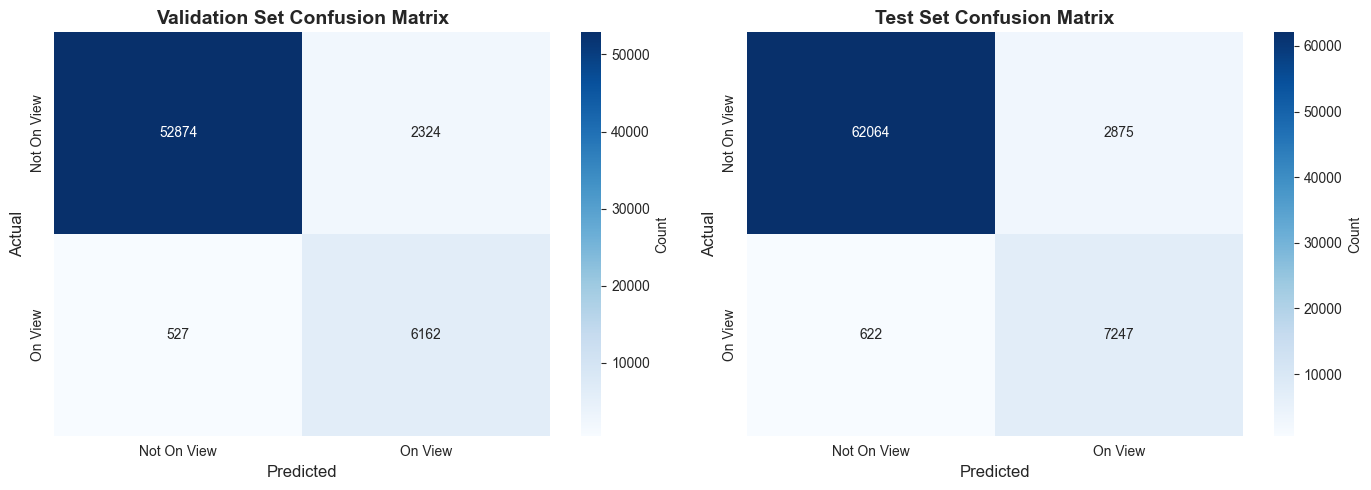

In [10]:
def plot_confusion_matrices(val_preds: Dict, test_preds: Dict) -> None:
    """Plot confusion matrices for validation and test sets."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    for idx, (preds, name, ax) in enumerate(zip([val_preds, test_preds], ["Validation", "Test"], axes)):
        cm = confusion_matrix(preds["true"], preds["pred"])
        
        sns.heatmap(
            cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            ax=ax,
            cbar_kws={"label": "Count"},
            xticklabels=["Not On View", "On View"],
            yticklabels=["Not On View", "On View"],
        )
        
        ax.set_xlabel("Predicted", fontsize=12)
        ax.set_ylabel("Actual", fontsize=12)
        ax.set_title(f"{name} Set Confusion Matrix", fontsize=14, fontweight="bold")
    
    plt.tight_layout()
    plt.show()


plot_confusion_matrices(val_preds, test_preds)


In [11]:
# Note: For detailed precision, recall, F1, and AUC metrics, see evaluate.ipynb
# This notebook focuses on understanding error patterns, not reporting overall metrics


## 5. Error Analysis by Metadata Features

Analyze errors across different object characteristics.


In [12]:
def analyze_errors_by_category(
    df_errors: pd.DataFrame,
    category_col: str,
    split_name: str = "Test",
    min_samples: int = 100,
    top_n: int = 15
) -> pd.DataFrame:
    """
    Analyze error rates by a categorical feature.
    
    Returns:
        DataFrame with error statistics per category
    """
    if category_col not in df_errors.columns:
        print(f"Column '{category_col}' not found in dataframe")
        return pd.DataFrame()
    
    # Filter to categories with sufficient samples
    category_counts = df_errors[category_col].value_counts()
    valid_categories = category_counts[category_counts >= min_samples].index
    
    df_filtered = df_errors[df_errors[category_col].isin(valid_categories)].copy()
    
    if len(df_filtered) == 0:
        print(f"No categories with at least {min_samples} samples")
        return pd.DataFrame()
    
    # Calculate error statistics
    error_stats = df_filtered.groupby(category_col).agg({
        "is_correct": ["count", "sum"],
        "is_false_positive": "sum",
        "is_false_negative": "sum",
        "pred_proba": "mean",
        "true": "mean",  # Proportion of positive class
    }).reset_index()
    
    error_stats.columns = [
        category_col, "total", "correct", "fp", "fn", 
        "avg_pred_proba", "true_positive_rate"
    ]
    
    error_stats["error_rate"] = 1 - (error_stats["correct"] / error_stats["total"])
    error_stats["fp_rate"] = error_stats["fp"] / error_stats["total"]
    error_stats["fn_rate"] = error_stats["fn"] / error_stats["total"]
    error_stats["accuracy"] = error_stats["correct"] / error_stats["total"]
    
    # Sort by error rate
    error_stats = error_stats.sort_values("error_rate", ascending=False)
    
    return error_stats.head(top_n)


# Analyze by department if available
if "department" in df_test_errors.columns:
    dept_errors = analyze_errors_by_category(df_test_errors, "department", "Test", min_samples=50)
    if len(dept_errors) > 0:
        print("ERROR RATES BY DEPARTMENT (Top 15)")
        print("=" * 80)
        print(dept_errors[["department", "total", "error_rate", "fp_rate", "fn_rate", "accuracy"]].to_string(index=False))


ERROR RATES BY DEPARTMENT (Top 15)
                            department  total  error_rate  fp_rate  fn_rate  accuracy
                    European Paintings    409    0.464548 0.405868 0.058680  0.535452
                         The Cloisters    383    0.274151 0.263708 0.010444  0.725849
              Robert Lehman Collection    398    0.203518 0.180905 0.022613  0.796482
                     The American Wing   2823    0.165427 0.159405 0.006022  0.834573
                          Egyptian Art   4192    0.141698 0.139552 0.002147  0.858302
                          Medieval Art   1148    0.140244 0.123693 0.016551  0.859756
                   Musical Instruments    748    0.132353 0.072193 0.060160  0.867647
                   Greek and Roman Art   5002    0.114954 0.104558 0.010396  0.885046
                        Arms and Armor   2090    0.106220 0.066986 0.039234  0.893780
                         The Libraries     85    0.105882 0.000000 0.105882  0.894118
                   

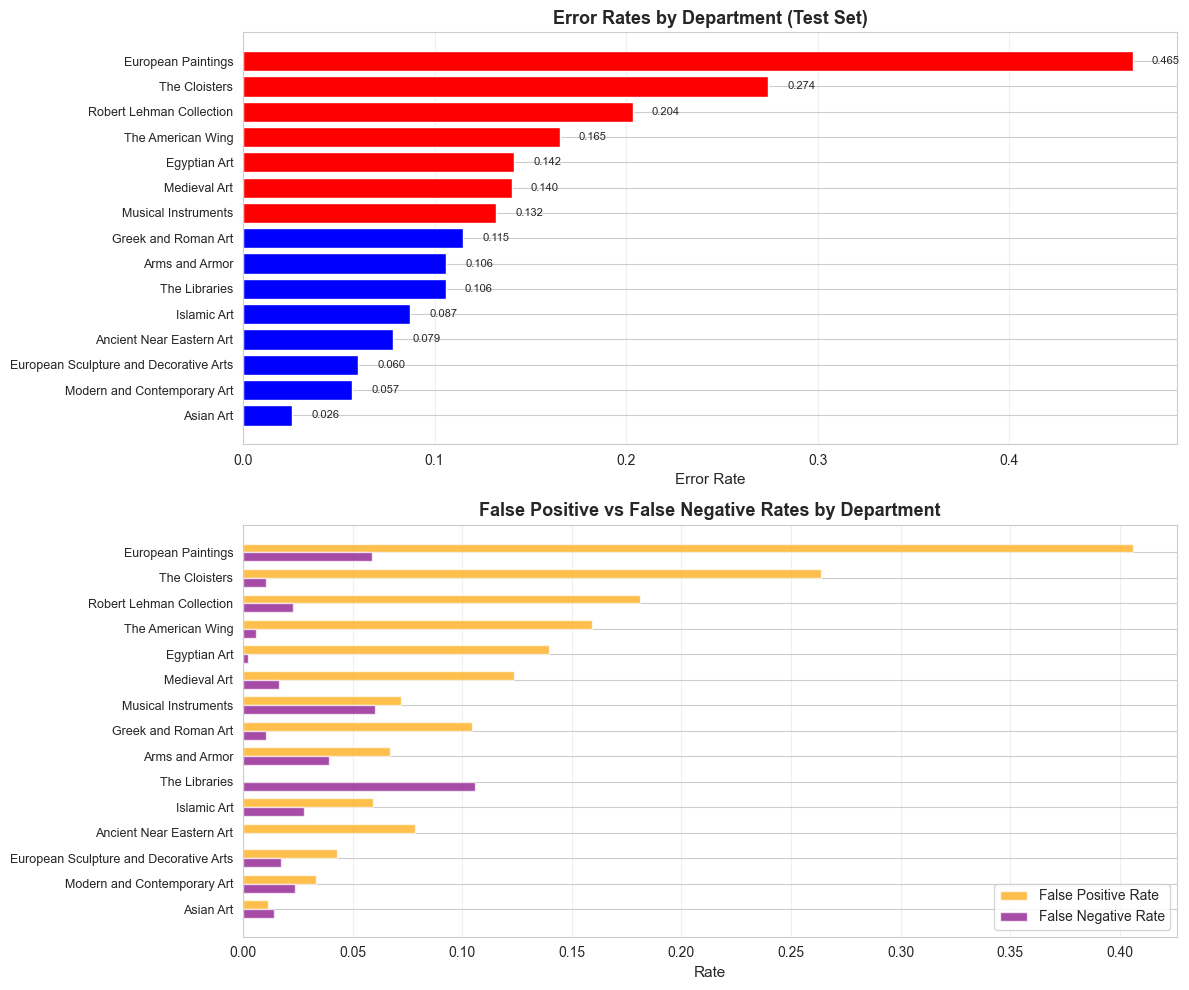

In [13]:
def plot_error_rates_by_category(
    df_errors: pd.DataFrame,
    category_col: str,
    split_name: str = "Test",
    min_samples: int = 100,
    top_n: int = 15
) -> None:
    """Plot error rates by category."""
    error_stats = analyze_errors_by_category(df_errors, category_col, split_name, min_samples, top_n)
    
    if len(error_stats) == 0:
        return
    
    fig, axes = plt.subplots(2, 1, figsize=(12, 10))
    
    # Error rate plot
    ax1 = axes[0]
    colors = ["red" if x > error_stats["error_rate"].median() else "blue" 
              for x in error_stats["error_rate"]]
    bars = ax1.barh(range(len(error_stats)), error_stats["error_rate"], color=colors)
    ax1.set_yticks(range(len(error_stats)))
    ax1.set_yticklabels(error_stats[category_col], fontsize=9)
    ax1.set_xlabel("Error Rate", fontsize=11)
    ax1.set_title(f"Error Rates by {category_col.title()} ({split_name} Set)", 
                  fontsize=13, fontweight="bold")
    ax1.grid(axis="x", alpha=0.3)
    ax1.invert_yaxis()
    
    # Add value labels
    for i, (idx, row) in enumerate(error_stats.iterrows()):
        ax1.text(row["error_rate"] + 0.01, i, f"{row['error_rate']:.3f}", 
                va="center", fontsize=8)
    
    # FP vs FN plot
    ax2 = axes[1]
    x_pos = np.arange(len(error_stats))
    width = 0.35
    
    ax2.barh(x_pos - width/2, error_stats["fp_rate"], width, 
             label="False Positive Rate", color="orange", alpha=0.7)
    ax2.barh(x_pos + width/2, error_stats["fn_rate"], width, 
             label="False Negative Rate", color="purple", alpha=0.7)
    
    ax2.set_yticks(x_pos)
    ax2.set_yticklabels(error_stats[category_col], fontsize=9)
    ax2.set_xlabel("Rate", fontsize=11)
    ax2.set_title(f"False Positive vs False Negative Rates by {category_col.title()}", 
                  fontsize=13, fontweight="bold")
    ax2.legend()
    ax2.grid(axis="x", alpha=0.3)
    ax2.invert_yaxis()
    
    plt.tight_layout()
    plt.show()


# Plot department errors if available
if "department" in df_test_errors.columns:
    plot_error_rates_by_category(df_test_errors, "department", "Test", min_samples=50, top_n=15)


ERROR RATES BY CENTURY
 date_century  total  error_rate  fp_rate  fn_rate
         -400    424    0.273585 0.261792 0.011792
         -100    345    0.257971 0.231884 0.026087
          100    240    0.254167 0.229167 0.025000
        -1900    195    0.246154 0.241026 0.005128
         -200    119    0.210084 0.193277 0.016807
         -300    274    0.186131 0.178832 0.007299
        -1100    215    0.181395 0.181395 0.000000
            0    654    0.175841 0.160550 0.015291
         1400   1160    0.172414 0.149138 0.023276
        -1800     69    0.159420 0.159420 0.000000
         -800    232    0.146552 0.129310 0.017241
         1100    512    0.142578 0.134766 0.007812
         1300    542    0.142066 0.127306 0.014760
        -2200     66    0.136364 0.136364 0.000000
        -1200    206    0.135922 0.135922 0.000000
        -2100    180    0.133333 0.127778 0.005556
         1200    426    0.124413 0.100939 0.023474
          300    349    0.123209 0.111748 0.011461
        

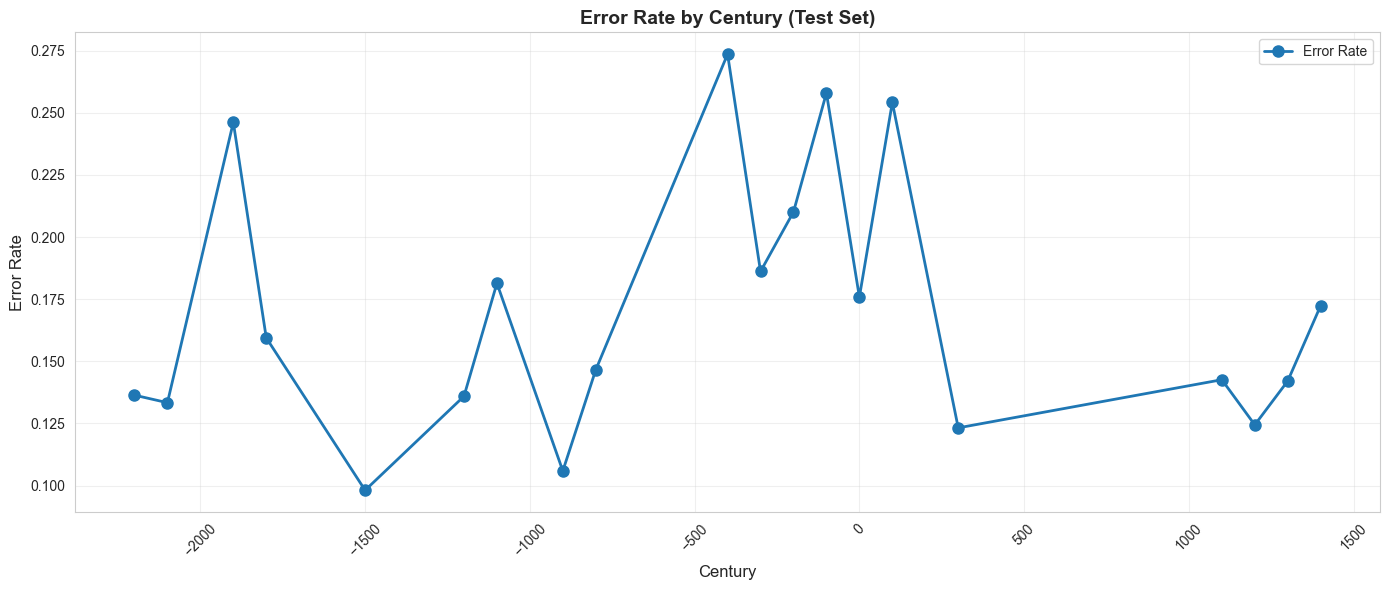

In [14]:
# Analyze by date ranges if objectBeginDate is available
if "objectBeginDate" in df_test_errors.columns:
    df_test_errors["date_century"] = (df_test_errors["objectBeginDate"] // 100) * 100
    df_test_errors["date_century"] = df_test_errors["date_century"].fillna("Unknown")
    
    date_errors = analyze_errors_by_category(
        df_test_errors, "date_century", "Test", min_samples=50, top_n=20
    )
    
    if len(date_errors) > 0:
        print("ERROR RATES BY CENTURY")
        print("=" * 80)
        print(date_errors[["date_century", "total", "error_rate", "fp_rate", "fn_rate"]].to_string(index=False))
        
        # Plot
        fig, ax = plt.subplots(figsize=(14, 6))
        date_errors_sorted = date_errors.sort_values("date_century")
        
        ax.plot(date_errors_sorted["date_century"], date_errors_sorted["error_rate"], 
                marker="o", linewidth=2, markersize=8, label="Error Rate")
        ax.set_xlabel("Century", fontsize=12)
        ax.set_ylabel("Error Rate", fontsize=12)
        ax.set_title("Error Rate by Century (Test Set)", fontsize=14, fontweight="bold")
        ax.grid(alpha=0.3)
        ax.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()


## 6. Prediction Confidence Analysis

Analyze how prediction confidence relates to errors.


C:\Users\Georgi\AppData\Local\Temp\ipykernel_14732\3310629522.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax2.boxplot(data_to_plot, labels=["Correct", "False\nPositive", "False\nNegative"],


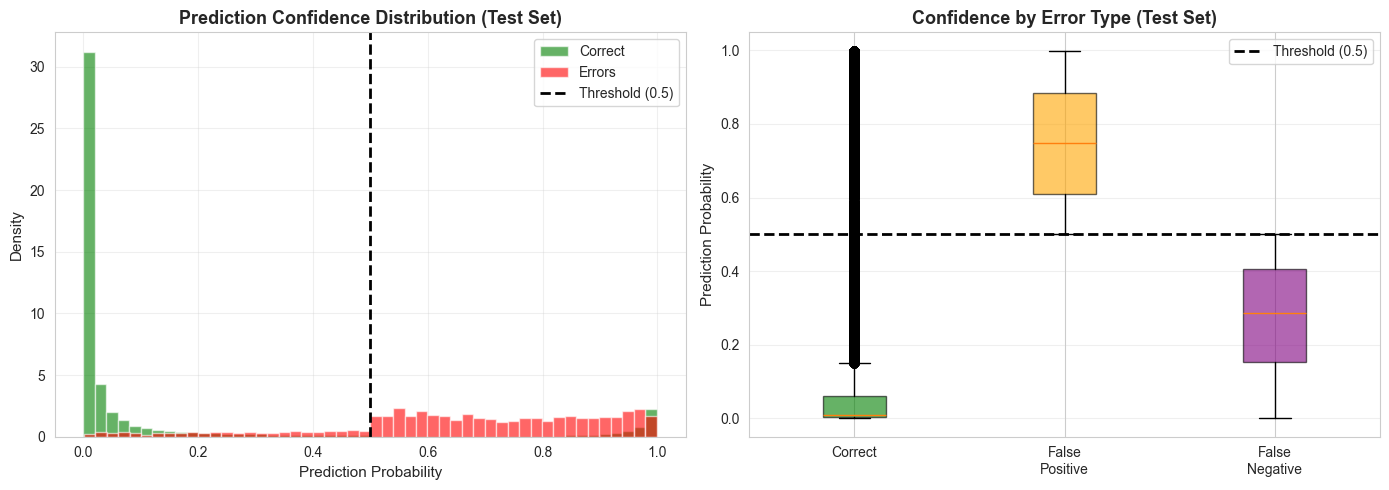

In [15]:
def plot_confidence_distributions(df_errors: pd.DataFrame, split_name: str = "Test") -> None:
    """Plot prediction confidence distributions for correct vs incorrect predictions."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Distribution plot
    ax1 = axes[0]
    correct_proba = df_errors[df_errors["is_correct"]]["pred_proba"]
    error_proba = df_errors[~df_errors["is_correct"]]["pred_proba"]
    
    ax1.hist(correct_proba, bins=50, alpha=0.6, label="Correct", color="green", density=True)
    ax1.hist(error_proba, bins=50, alpha=0.6, label="Errors", color="red", density=True)
    ax1.axvline(CONFIG["threshold"], color="black", linestyle="--", linewidth=2, label=f"Threshold ({CONFIG['threshold']})")
    ax1.set_xlabel("Prediction Probability", fontsize=11)
    ax1.set_ylabel("Density", fontsize=11)
    ax1.set_title(f"Prediction Confidence Distribution ({split_name} Set)", fontsize=13, fontweight="bold")
    ax1.legend()
    ax1.grid(alpha=0.3)
    
    # Box plot by error type
    ax2 = axes[1]
    error_types = ["correct", "false_positive", "false_negative"]
    data_to_plot = [df_errors[df_errors["error_type"] == et]["pred_proba"].values for et in error_types]
    
    bp = ax2.boxplot(data_to_plot, labels=["Correct", "False\nPositive", "False\nNegative"], 
                     patch_artist=True)
    colors = ["green", "orange", "purple"]
    for patch, color in zip(bp["boxes"], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)
    
    ax2.axhline(CONFIG["threshold"], color="black", linestyle="--", linewidth=2, label=f"Threshold ({CONFIG['threshold']})")
    ax2.set_ylabel("Prediction Probability", fontsize=11)
    ax2.set_title(f"Confidence by Error Type ({split_name} Set)", fontsize=13, fontweight="bold")
    ax2.grid(axis="y", alpha=0.3)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()


plot_confidence_distributions(df_test_errors, "Test")


C:\Users\Georgi\AppData\Local\Temp\ipykernel_14732\2916659073.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = df_errors.groupby("confidence_bin").agg({


ERROR RATES BY CONFIDENCE BIN (Test Set)
confidence_bin  total  correct  fp  fn  error_rate  accuracy
       0.0-0.1  55063    54951   0 112    0.002034  0.997966
       0.1-0.2   3462     3361   0 101    0.029174  0.970826
       0.2-0.3   1911     1793   0 118    0.061748  0.938252
       0.3-0.4   1267     1140   0 127    0.100237  0.899763
       0.4-0.5    978      815   0 163    0.166667  0.833333
       0.5-0.6    850      197 652   1    0.768235  0.231765
       0.6-0.7    843      275 568   0    0.673784  0.326216
       0.7-0.8    883      398 485   0    0.549264  0.450736
       0.8-0.9   1297      767 530   0    0.408635  0.591365
       0.9-1.0   6254     5614 640   0    0.102335  0.897665


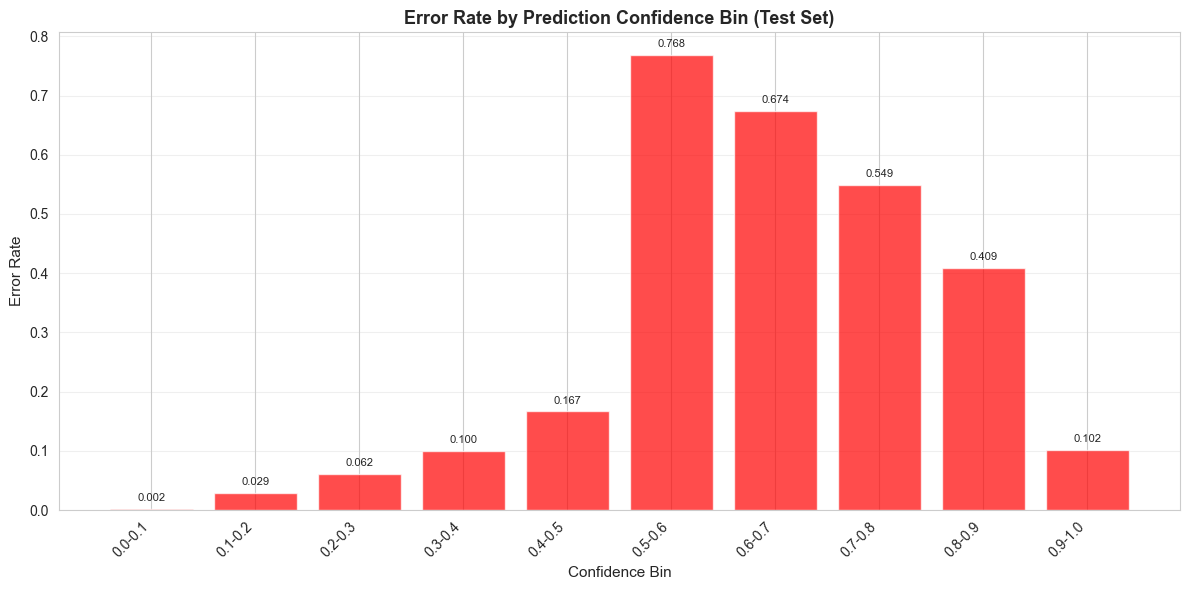

In [16]:
def analyze_confidence_bins(df_errors: pd.DataFrame, n_bins: int = 10) -> pd.DataFrame:
    """Analyze error rates across confidence bins."""
    df_errors = df_errors.copy()
    df_errors["confidence_bin"] = pd.cut(df_errors["pred_proba"], bins=n_bins, 
                                         labels=[f"{(i/n_bins):.1f}-{((i+1)/n_bins):.1f}" 
                                                for i in range(n_bins)])
    
    bin_stats = df_errors.groupby("confidence_bin").agg({
        "is_correct": ["count", "sum"],
        "is_false_positive": "sum",
        "is_false_negative": "sum",
    }).reset_index()
    
    bin_stats.columns = ["confidence_bin", "total", "correct", "fp", "fn"]
    bin_stats["error_rate"] = 1 - (bin_stats["correct"] / bin_stats["total"])
    bin_stats["accuracy"] = bin_stats["correct"] / bin_stats["total"]
    
    return bin_stats


conf_bins = analyze_confidence_bins(df_test_errors, n_bins=10)
print("ERROR RATES BY CONFIDENCE BIN (Test Set)")
print("=" * 70)
print(conf_bins.to_string(index=False))

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
x_pos = np.arange(len(conf_bins))
ax.bar(x_pos, conf_bins["error_rate"], color="red", alpha=0.7)
ax.set_xticks(x_pos)
ax.set_xticklabels(conf_bins["confidence_bin"], rotation=45, ha="right")
ax.set_xlabel("Confidence Bin", fontsize=11)
ax.set_ylabel("Error Rate", fontsize=11)
ax.set_title("Error Rate by Prediction Confidence Bin (Test Set)", fontsize=13, fontweight="bold")
ax.grid(axis="y", alpha=0.3)

# Add value labels
for i, row in conf_bins.iterrows():
    ax.text(i, row["error_rate"] + 0.01, f"{row['error_rate']:.3f}", 
           ha="center", va="bottom", fontsize=8)

plt.tight_layout()
plt.show()


## 7. Feature Importance for Errors

Analyze which features are most important for incorrect predictions.


TOP 30 MOST IMPORTANT FEATURES
        feature  importance
  objectEndDate    7.488980
objectBeginDate    4.286555
        emb_925    1.001549
        emb_161    0.959221
        emb_239    0.953608
        emb_481    0.928322
        emb_640    0.903866
        emb_313    0.886935
        emb_792    0.832999
        emb_332    0.735173
        emb_418    0.728891
        emb_202    0.600692
        emb_333    0.573668
        emb_488    0.557448
        emb_118    0.539715
        emb_830    0.524363
        emb_966    0.488985
        emb_675    0.479468
        emb_334    0.431054
         emb_30    0.429190
        emb_111    0.424128
        emb_870    0.415396
        emb_873    0.406252
        emb_644    0.399873
        emb_341    0.399559
         emb_39    0.397365
        emb_668    0.397044
        emb_303    0.396363
        emb_868    0.395319
        emb_611    0.394536


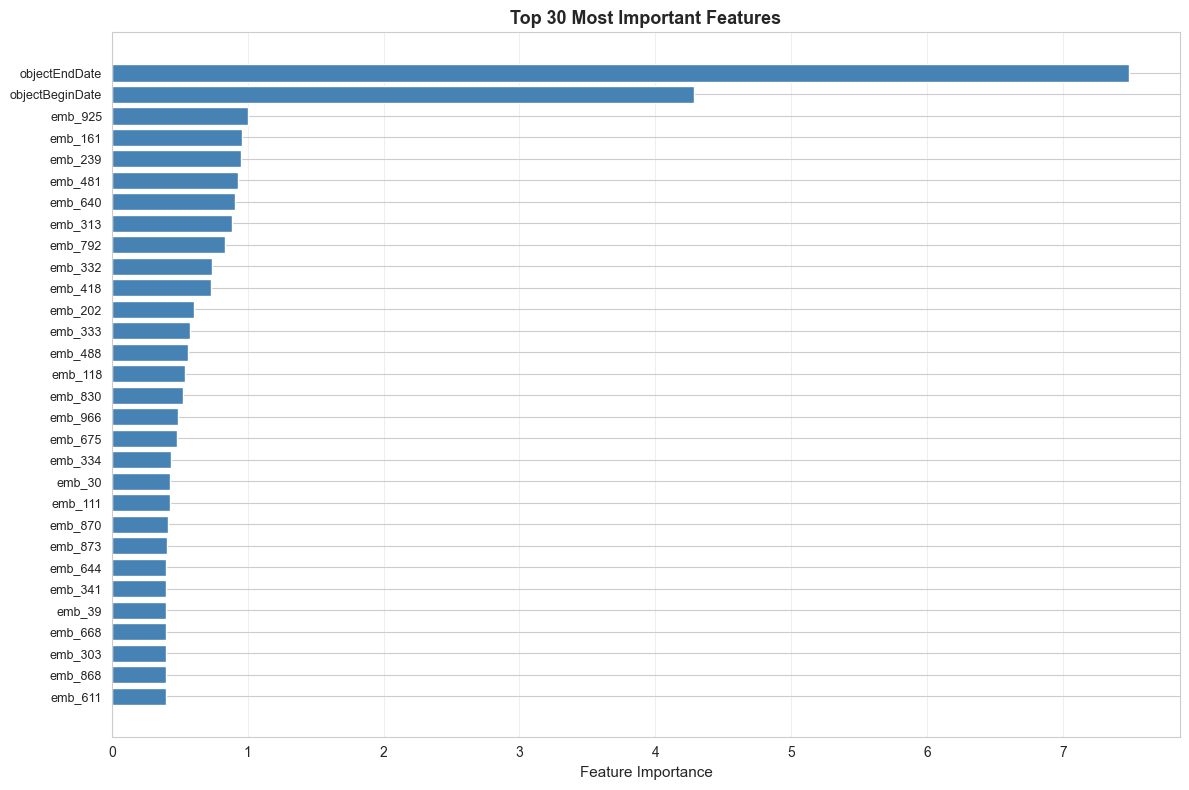

In [17]:
# Get feature importance from model
feature_importance = model.get_feature_importance()
df_feature_importance = pd.DataFrame({
    "feature": feature_columns_processed,
    "importance": feature_importance,
}).sort_values("importance", ascending=False)

print("TOP 30 MOST IMPORTANT FEATURES")
print("=" * 60)
print(df_feature_importance.head(30).to_string(index=False))

# Plot top features
fig, ax = plt.subplots(figsize=(12, 8))
top_n = 30
top_features = df_feature_importance.head(top_n)

ax.barh(range(len(top_features)), top_features["importance"], color="steelblue")
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features["feature"], fontsize=9)
ax.set_xlabel("Feature Importance", fontsize=11)
ax.set_title(f"Top {top_n} Most Important Features", fontsize=13, fontweight="bold")
ax.grid(axis="x", alpha=0.3)
ax.invert_yaxis()

plt.tight_layout()
plt.show()


In [18]:
def compare_feature_values_for_errors(
    df_errors: pd.DataFrame,
    feature_col: str,
    split_name: str = "Test"
) -> pd.DataFrame:
    """
    Compare feature values between correct and incorrect predictions.
    Only works for numeric features in the metadata.
    """
    if feature_col not in df_errors.columns:
        return pd.DataFrame()
    
    if not pd.api.types.is_numeric_dtype(df_errors[feature_col]):
        print(f"Feature '{feature_col}' is not numeric")
        return pd.DataFrame()
    
    comparison = df_errors.groupby("is_correct")[feature_col].agg([
        "count", "mean", "median", "std", "min", "max"
    ]).reset_index()
    
    comparison.columns = ["is_correct", "count", "mean", "median", "std", "min", "max"]
    comparison["is_correct"] = comparison["is_correct"].map({True: "Correct", False: "Errors"})
    
    return comparison


# Compare key numeric features
numeric_features = ["objectBeginDate", "objectEndDate", "accessionYear"]
available_numeric = [f for f in numeric_features if f in df_test_errors.columns]

if available_numeric:
    print("FEATURE VALUE COMPARISON: CORRECT vs ERRORS")
    print("=" * 80)
    for feat in available_numeric:
        comp = compare_feature_values_for_errors(df_test_errors, feat, "Test")
        if len(comp) > 0:
            print(f"\n{feat.upper()}:")
            print(comp.to_string(index=False))
            print()


FEATURE VALUE COMPARISON: CORRECT vs ERRORS

OBJECTBEGINDATE:
is_correct  count        mean  median         std    min  max
    Errors   3497  695.884186  1450.0 1346.285234  -7000 2022
   Correct  69311 1341.185007  1800.0 1288.734981 -90000 2024


OBJECTENDDATE:
is_correct  count        mean  median         std    min  max
    Errors   3497  788.357735  1499.0 1285.256557  -4000 2022
   Correct  69311 1437.889585  1849.0  965.750207 -35000 2059


ACCESSIONYEAR:
is_correct  count        mean  median       std    min    max
    Errors   3446 1942.262043  1932.0 40.354778 1871.0 2056.0
   Correct  68772 1956.478567  1959.0 35.235699 1871.0 2056.0



## 8. Error Examples

Examine specific examples of misclassified objects.


In [19]:
import pandas as pd
from IPython.display import display

def display_error_examples(
    df_errors: pd.DataFrame,
    error_type: str = "false_positive",
    n_examples: int = 10,
    split_name: str = "Test",
    text_wrap_px: int = 280,
) -> pd.DataFrame:
    """
    Display examples of specific error type in a Jupyter-friendly styled table.

    Args:
        error_type: 'false_positive' or 'false_negative'
        n_examples: Number of examples to show
        split_name: Name shown in the header
        text_wrap_px: Max width for text columns before wrapping
    """
    if error_type == "false_positive":
        mask = df_errors["is_false_positive"]
        title = "FALSE POSITIVES (Predicted On View, Actually Not)"
        error_examples = df_errors[mask].nlargest(n_examples, "pred_proba")
        header_color = "#ffe5e5"
    elif error_type == "false_negative":
        mask = df_errors["is_false_negative"]
        title = "FALSE NEGATIVES (Predicted Not On View, Actually On View)"
        error_examples = df_errors[mask].nsmallest(n_examples, "pred_proba")
        header_color = "#fff6e0"
    else:
        raise ValueError("error_type must be 'false_positive' or 'false_negative'")

    # Select relevant columns
    base_cols = ["objectID", "pred_proba", "pred", "true"]
    metadata_cols = [
        "department", "title", "objectName", "culture", "period",
        "objectBeginDate", "objectEndDate", "medium", "classification"
    ]
    display_cols = base_cols + [c for c in metadata_cols if c in error_examples.columns]

    display_df = error_examples[display_cols].copy()

    # Basic formatting / types
    if "pred_proba" in display_df.columns:
        display_df["pred_proba"] = pd.to_numeric(display_df["pred_proba"], errors="coerce")

    # Print a small readable header (optional)
    confidence_desc = "highest confidence" if error_type == "false_positive" else "lowest confidence"
    print(f"\n{title} ({split_name} set) — showing {len(display_df)} examples ({confidence_desc} errors)\n")

    # Build a Jupyter-friendly Styler
    text_cols = [c for c in ["department","title","objectName","culture","period","medium","classification"] if c in display_df.columns]
    num_cols = [c for c in ["pred_proba","objectBeginDate","objectEndDate"] if c in display_df.columns]

    styler = (
        display_df.style
        # numeric formatting
        .format({"pred_proba": "{:.3f}"} if "pred_proba" in display_df.columns else {})
    )

    # Reapply formatting if .bar() replaced styler
    if "pred_proba" in display_df.columns:
        styler = styler.format({"pred_proba": "{:.3f}"})

    styler = (
        styler
        # wrap text columns nicely
        .set_properties(subset=text_cols, **{
            "white-space": "pre-wrap",
            "max-width": f"{text_wrap_px}px",
            "overflow-wrap": "anywhere",
            "vertical-align": "top",
        })
        # keep numeric columns compact
        .set_properties(subset=num_cols, **{"text-align": "right"})
        .set_properties(subset=[c for c in ["objectID","pred","true"] if c in display_df.columns], **{"text-align": "center"})
        # table styling
        .set_table_styles([
            {"selector": "th", "props": [("background-color", header_color), ("font-weight", "600"), ("text-align", "center")]},
            {"selector": "td", "props": [("padding", "6px 8px")]},
            {"selector": "table", "props": [("border-collapse", "collapse")]},
        ])
    )

    # Make it horizontally scrollable if wide
    display(styler.set_table_attributes('style="display:block; overflow-x:auto; white-space:nowrap;"'))

    return display_df


# Example usage
fp_examples = display_error_examples(df_test_errors, "false_positive", n_examples=15, split_name="Test")




FALSE POSITIVES (Predicted On View, Actually Not) (Test set) — showing 15 examples (highest confidence errors)



,objectID,pred_proba,pred,true,department,title,objectName,culture,objectBeginDate,objectEndDate,medium,classification
55115,562350,0.999,1,0,Egyptian Art,"Relief fragment, tomb of Meketre","Relief fragment, tomb of Meketre",,-1981,-1975,"Limestone, paint",
20956,561296,0.997,1,0,Egyptian Art,Fragment of the Center Top Surface of Siptah's Canopic Chest,"Canopic chest fragments, Siptah",,-1194,-1194,Travertine (Egyptian alabaster),
3869,667,0.997,1,0,The American Wing,Bowl,Bowl,Mexican,1747,1800,Tin-glazed earthenware,
17729,544759,0.996,1,0,Egyptian Art,Tiles from the railing of a throne dais of Ramesses II,"Tile, palace of Ramesses II",,-1279,-1279,"Faience, paint",
53220,550951,0.996,1,0,Egyptian Art,Scarab,Scarab,,-664,-664,Lapis lazuli,
35687,549261,0.996,1,0,Egyptian Art,Figure of Hapy,"Hapy, son of Horus",,-1295,-1295,Faience,
21521,569788,0.996,1,0,Egyptian Art,Mummy of a Monkey,"Mummy, monkey",,-1295,-1295,Animal remains,
72450,552511,0.995,1,0,Egyptian Art,Sistrum amulet,"Amulet, sistrum",,-1070,-1070,Blue-green faience,
40740,548749,0.994,1,0,Egyptian Art,Scarab Finger Ring,"Ring, scarab",,-1560,-1560,"Gold, glazed steatite",
59434,5662,0.994,1,0,The American Wing,Pitcher,Pitcher,American,1830,1850,Blown glass with applied decoration,


In [20]:
# Display false negative examples
fn_examples = display_error_examples(df_test_errors, "false_negative", n_examples=15, split_name="Test")



FALSE NEGATIVES (Predicted Not On View, Actually On View) (Test set) — showing 15 examples (lowest confidence errors)



,objectID,pred_proba,pred,true,department,title,objectName,culture,objectBeginDate,objectEndDate,medium,classification
4802,347780,0.001,0,1,Drawings and Prints,Scrapbook of Drawings and Prints,Album Drawing Ornament and Architecture,,1755,1765,"Pen and ink, engraving and etching",Albums
24467,491422,0.001,0,1,Modern and Contemporary Art,Boulevard de Strasbourg,Print,,1950,1950,Color lithograph,Prints
59074,924718,0.004,0,1,The Libraries,Critics' show,,,1946,1946,,
63050,660347,0.005,0,1,Photographs,African Masks After Walker Evans: 1–24,Photograph; portfolio,,2014,2014,Inkjet prints,Photographs
14707,261175,0.007,0,1,Photographs,"William Russell Bogert, Jr.",Photograph,,1922,1922,Gelatin silver print,Photographs
69090,893955,0.009,0,1,Drawings and Prints,General Washington,Print,,1781,1781,Mezzotint; first state of two,Prints
35348,125074,0.011,0,1,Costume Institute,Shoe buckles,Shoe Buckles,British,1700,1799,metal,
24000,904813,0.012,0,1,Drawings and Prints,He Disappeared into Complete Silence,Print; Portfolio,,1947,1947,Engraving and drypoint with letterpress in a linen portfolio cover,Prints
36356,397121,0.015,0,1,Drawings and Prints,"""Hartsel Strikes Out,"" with Robert Groom and Dolly Grey, from the series Hassan Triple Folders (T202)","Baseball card, print",,1912,1912,Commercial lithographs with half-tone photograph,Prints
4142,454005,0.015,0,1,Islamic Art,Fragments of a Bowl,Fragments,,800,999,Porcelain,Ceramics


## 9. Error Patterns Summary

Summarize key findings and patterns discovered in the error analysis.


In [21]:
# Note: ROC and Precision-Recall curves are overall performance metrics.
# For those visualizations, see evaluate.ipynb. This section focuses on error-specific insights.


## 10. Key Insights and Recommendations

Summarize key findings from the error analysis.


In [22]:
def generate_error_insights(df_errors: pd.DataFrame, split_name: str = "Test") -> Dict:
    """Generate error-focused insights (not overall metrics)."""
    insights = {
        "split": split_name,
        "total_errors": (~df_errors["is_correct"]).sum(),
        "error_rate": 1 - df_errors["is_correct"].mean(),
        "fp_count": df_errors["is_false_positive"].sum(),
        "fn_count": df_errors["is_false_negative"].sum(),
        "avg_confidence_correct": df_errors[df_errors["is_correct"]]["pred_proba"].mean(),
        "avg_confidence_errors": df_errors[~df_errors["is_correct"]]["pred_proba"].mean(),
        "avg_confidence_fp": df_errors[df_errors["is_false_positive"]]["pred_proba"].mean() if df_errors["is_false_positive"].sum() > 0 else 0,
        "avg_confidence_fn": df_errors[df_errors["is_false_negative"]]["pred_proba"].mean() if df_errors["is_false_negative"].sum() > 0 else 0,
    }
    
    # Add category-specific insights if available
    if "department" in df_errors.columns:
        dept_errors = analyze_errors_by_category(df_errors, "department", split_name, min_samples=50, top_n=3)
        if len(dept_errors) > 0:
            insights["departments_with_most_errors"] = dept_errors["department"].tolist()
            insights["highest_error_rate_dept"] = dept_errors.iloc[0]["department"]
    
    return insights


test_insights = generate_error_insights(df_test_errors, "Test")
val_insights = generate_error_insights(df_val_errors, "Validation")

print("KEY ERROR INSIGHTS")
print("=" * 80)
print("\nTEST SET:")
print(f"  Total errors:                    {test_insights['total_errors']:,}")
print(f"  Error rate:                      {test_insights['error_rate']:.4f}")
print(f"  False positives:                 {test_insights['fp_count']:,}")
print(f"  False negatives:                 {test_insights['fn_count']:,}")
print(f"  Avg confidence (correct):        {test_insights['avg_confidence_correct']:.4f}")
print(f"  Avg confidence (errors):         {test_insights['avg_confidence_errors']:.4f}")
print(f"  Avg confidence (FP):             {test_insights['avg_confidence_fp']:.4f}")
print(f"  Avg confidence (FN):             {test_insights['avg_confidence_fn']:.4f}")

if "departments_with_most_errors" in test_insights:
    print(f"\n  Departments with most errors:    {', '.join(test_insights['departments_with_most_errors'])}")

print("\nVALIDATION SET:")
print(f"  Total errors:                    {val_insights['total_errors']:,}")
print(f"  Error rate:                      {val_insights['error_rate']:.4f}")
print(f"  False positives:                 {val_insights['fp_count']:,}")
print(f"  False negatives:                 {val_insights['fn_count']:,}")
print(f"  Avg confidence (correct):        {val_insights['avg_confidence_correct']:.4f}")
print(f"  Avg confidence (errors):         {val_insights['avg_confidence_errors']:.4f}")
print(f"  Avg confidence (FP):             {val_insights['avg_confidence_fp']:.4f}")
print(f"  Avg confidence (FN):             {val_insights['avg_confidence_fn']:.4f}")

if "departments_with_most_errors" in val_insights:
    print(f"\n  Departments with most errors:    {', '.join(val_insights['departments_with_most_errors'])}")


KEY ERROR INSIGHTS

TEST SET:
  Total errors:                    3,497
  Error rate:                      0.0480
  False positives:                 2,875
  False negatives:                 622
  Avg confidence (correct):        0.1322
  Avg confidence (errors):         0.6637
  Avg confidence (FP):             0.7481
  Avg confidence (FN):             0.2739

  Departments with most errors:    European Paintings, The Cloisters, Robert Lehman Collection

VALIDATION SET:
  Total errors:                    2,851
  Error rate:                      0.0461
  False positives:                 2,324
  False negatives:                 527
  Avg confidence (correct):        0.1311
  Avg confidence (errors):         0.6567
  Avg confidence (FP):             0.7452
  Avg confidence (FN):             0.2668

  Departments with most errors:    European Paintings, The Cloisters, Robert Lehman Collection
